# RL and Advanced DL: Домашнее задание 2

## Imports & TicTacToe env

In [90]:
import gym

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable
import tqdm

In [91]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

In [92]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN, clone=None):
        if clone is not None:
            self.n_rows, self.n_cols, self.n_win = clone.n_rows, clone.n_cols, clone.n_win
            self.board = copy.deepcopy(clone.board)
            self.curTurn = clone.curTurn
            self.emptySpaces = None
            self.boardHash = None
        else:
            self.n_rows = n_rows
            self.n_cols = n_cols
            self.n_win = n_win

            self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

In [93]:
def plot_board(env, pi, showtext=True, verbose=True, fontq=20, fontx=60):
    '''Рисуем доску с оценками из стратегии pi'''
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    X, Y = np.meshgrid(np.arange(0, env.n_rows), np.arange(0, env.n_rows))
    Z = np.zeros((env.n_rows, env.n_cols)) + .01
    s, actions = env.getHash(), env.getEmptySpaces()
    if pi is not None and s in pi.Q:
        for i, a in enumerate(actions):
            Z[a[0], a[1]] = pi.Q[s][i]
    ax.set_xticks([])
    ax.set_yticks([])
    surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 10), vmin=-1, vmax=1)
    if showtext:
        for i,a in enumerate(actions):
            if pi is not None and s in pi.Q:
                ax.text( a[1] , a[0] , "%.3f" % pi.Q[s][i], fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
    for i in range(env.n_rows):
        for j in range(env.n_cols):
            if env.board[i, j] == -1:
                ax.text(j, i, "O", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
            if env.board[i, j] == 1:
                ax.text(j, i, "X", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
    cbar = plt.colorbar(surf, ticks=[0, 1])
    ax.grid(False)
    plt.show()

def get_and_print_move(env, pi, s, actions, random=False, verbose=True, fontq=20, fontx=60):
    '''Делаем ход, рисуем доску'''
    plot_board(env, pi, fontq=fontq, fontx=fontx)
    if verbose and (pi is not None):
        if s in pi.Q:
            for i,a in enumerate(actions):
                print(i, a, pi.Q[s][i])
        else:
            print("Стратегия не знает, что делать...")
    if random:
        return np.random.randint(len(actions))
    else:
        return pi.getActionGreedy(s, len(actions))

In [94]:
def plot_test_game(env, pi1, pi2, random_crosses=False, random_naughts=True, verbose=True, fontq=20, fontx=60):
    '''Играем тестовую партию между стратегиями или со случайными ходами, рисуем ход игры'''
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            a = get_and_print_move(env, pi1, s, actions, random=random_crosses, verbose=verbose, fontq=fontq, fontx=fontx)
        else:
            a = get_and_print_move(env, pi2, s, actions, random=random_naughts, verbose=verbose, fontq=fontq, fontx=fontx)
        observation, reward, done, info = env.step(actions[a])
        if reward == 1:
            print("Крестики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)
        if reward == -1:
            print("Нолики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)

## Часть первая: крестики-нолики при помощи Q-обучения

### 1. Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.

Реализуем Q-обучение с двумя политиками: первого и второго игрока.

In [95]:
def get_action(p, board_hash, empty_spaces, epsilon):
  empty_len = len(empty_spaces)
  if board_hash in p.Q and np.random.random() > epsilon:
    idx = np.argmax(p.Q[board_hash])
  else:
    idx = np.random.randint(empty_len)
    if board_hash not in p.Q:
      p.Q[board_hash] = np.zeros(empty_len)
  a = empty_spaces[idx]
  return a, idx

In [96]:
def QLearning(env, p_1, p_2, alpha=0.009, epsilon=0.3, gamma=1.0):
  env.reset()
  board_hash, empty_spaces, cur_turn = env.getState()
  reward, done = 0, False
  p_1_prev_s, p_1_prev_a = None, None
  p_2_prev_s, p_2_prev_a = None, None

  while not done:
      
    if cur_turn == 1:
      a, idx = get_action(p_1, board_hash, empty_spaces, epsilon)
      state, reward, done, _ = env.step(a)
      board_hash_main, empty_spaces_main, cur_turn_main = state
      
      if p_2_prev_s:
        gamma_t = gamma * np.max(p_2.Q[board_hash_main]) if board_hash_main in p_2.Q else 0
        p_2.Q[p_2_prev_s][p_2_prev_a] = p_2.Q[p_2_prev_s][p_2_prev_a] + alpha * (-reward + gamma_t - p_2.Q[p_2_prev_s][p_2_prev_a])
      if reward == 1:
        p_1.Q[board_hash][idx] = reward
      
      p_1_prev_s, p_1_prev_a = board_hash, idx

    elif cur_turn == -1:
      a, idx = get_action(p_2, board_hash, empty_spaces, epsilon)
      state, reward, done, _ = env.step(a)
      board_hash_main, empty_spaces_main, cur_turn_main = state
      
      if p_1_prev_s:
        gamma_t = gamma * np.max(p_1.Q[board_hash_main]) if board_hash_main in p_1.Q else 0
        p_1.Q[p_1_prev_s][p_1_prev_a] = p_1.Q[p_1_prev_s][p_1_prev_a] + alpha * (reward + gamma_t - p_1.Q[p_1_prev_s][p_1_prev_a])
      if reward == -1:
        p_2.Q[board_hash][idx] = -reward
      
      p_2_prev_s, p_2_prev_a = board_hash, idx
    
    else:
      raise Exception('Может быть только 2 игрока')
    
    board_hash, empty_spaces, cur_turn = board_hash_main, empty_spaces_main, cur_turn_main

In [97]:
def get_action_g(p, board_hash, empty_spaces):
  empty_len = len(empty_spaces)
  if p and board_hash in p.Q:
    idx = np.argmax(p.Q[board_hash])
  else:
    idx = np.random.randint(empty_len)
  a = empty_spaces[idx]
  return a, idx

In [98]:
def play_game(env, p_1=None, p_2=None):
  env.reset()
  board_hash, empty_spaces, cur_turn = env.getState()
  reward, done = 0, False

  while not done:
    if cur_turn == 1:
      a, idx = get_action_g(p_1, board_hash, empty_spaces)
      state, reward, done, _ = env.step(a)
      board_hash_main, empty_spaces_main, cur_turn_main = state
    elif cur_turn == -1:
      a, idx = get_action_g(p_2, board_hash, empty_spaces)
      state, reward, done, _ = env.step(a)
      board_hash_main, empty_spaces_main, cur_turn_main = state
    else:
      raise Exception('Может быть только 2 игрока')
    
    board_hash, empty_spaces, cur_turn = board_hash_main, empty_spaces_main, cur_turn_main
  
  return reward

In [99]:
def compare_p(env, p_1=None, p_2=None, episodes_num=1000):
    total_reward = 0
    for _ in range(episodes_num):
        total_reward += play_game(env, p_1=p_1, p_2=p_2)
    return total_reward / episodes_num

In [100]:
class Policy:
    def __init__(self):
        self.Q = {}
    
    def get_action(self, s, n):
        if s in self.Q:
            return np.argmax(self.Q[s])
        else:
            return np.random.randint(n)

In [101]:
def run_experiment(env, p_1, p_2, episodes, test_each, print_each):
  indexes, crosses, noughts = [], [], []

  for i in tqdm.tqdm(range(1, episodes + 1)):
    QLearning(env, p_1, p_2)
    if i % test_each == 0:
      cross = compare_p(env, p_1=p_1, p_2=None, episodes_num=500)
      nought = -compare_p(env, p_1=None, p_2=p_2, episodes_num=500)
      indexes.append(i)
      crosses.append(cross)
      noughts.append(nought)
    if i % print_each == 0:
      print(f'Episode {i}, cross reward: {cross}, nought reward: {nought}')

  indexes, crosses, noughts = np.array(indexes), np.array(crosses), np.array(noughts)
  results = np.vstack((indexes, crosses, noughts))

  return results

In [102]:
p_1 = Policy()
p_2 = Policy()
env = TicTacToe(3, 3, 3)

episodes = 200000
test_each = 1000
print_each = 20000

results_1 = run_experiment(env, p_1, p_2, episodes, test_each, print_each)

 10%|█         | 20224/200000 [00:27<04:55, 608.95it/s]

Episode 20000, cross reward: 0.988, nought reward: 0.64


 20%|██        | 40171/200000 [00:53<05:09, 516.52it/s]

Episode 40000, cross reward: 0.99, nought reward: 0.74


 30%|███       | 60245/200000 [01:18<04:05, 570.26it/s]

Episode 60000, cross reward: 0.998, nought reward: 0.794


 40%|████      | 80225/200000 [01:44<02:57, 674.95it/s]

Episode 80000, cross reward: 0.994, nought reward: 0.82


 50%|█████     | 100272/200000 [02:10<02:25, 684.15it/s]

Episode 100000, cross reward: 0.994, nought reward: 0.796


 60%|██████    | 120180/200000 [02:35<02:06, 631.46it/s]

Episode 120000, cross reward: 0.994, nought reward: 0.87


 70%|███████   | 140294/200000 [03:01<01:35, 622.26it/s]

Episode 140000, cross reward: 0.998, nought reward: 0.848


 80%|████████  | 160153/200000 [03:27<01:01, 652.70it/s]

Episode 160000, cross reward: 0.99, nought reward: 0.87


 90%|█████████ | 180223/200000 [03:52<00:30, 638.44it/s]

Episode 180000, cross reward: 0.998, nought reward: 0.848


100%|██████████| 200000/200000 [04:18<00:00, 773.35it/s] 

Episode 200000, cross reward: 0.99, nought reward: 0.856


In [103]:
def plot_results(results):
    plt.xlabel('Эпизодов')
    plt.ylabel('Средний выигрыш')
    plt.plot(results[0], results[1], label='Крестики')
    plt.plot(results[0], results[2], label='Нолики')
    plt.legend()

Средний выигрышь крестиков против случайной политики: 0.994
Средний выигрышь ноликов против случайной политики: 0.86


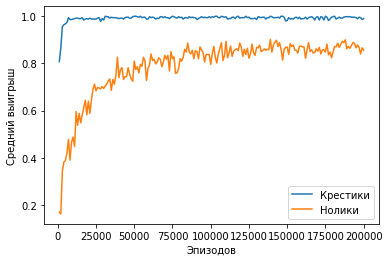

In [104]:
plot_results(results_1)
print(f'Средний выигрышь крестиков против случайной политики: {np.round(np.mean(results_1[1][-100:-1]), 3)}')
print(f'Средний выигрышь ноликов против случайной политики: {np.round(np.mean(results_1[2][-100:-1]), 3)}')

### 2. Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.

In [106]:
p_1 = Policy()
p_2 = Policy()
env = TicTacToe(4, 4, 4)

episodes = 1000000
test_each = 1000
print_each = 100000

results_2 = run_experiment(env, p_1, p_2, episodes, test_each, print_each)

 10%|█         | 100091/1000000 [05:22<1:42:10, 146.79it/s]

Episode 100000, cross reward: 0.372, nought reward: 0.018


 20%|██        | 200078/1000000 [10:35<1:32:30, 144.11it/s]

Episode 200000, cross reward: 0.498, nought reward: 0.018


 30%|███       | 300076/1000000 [15:46<1:12:42, 160.43it/s]

Episode 300000, cross reward: 0.59, nought reward: 0.074


 40%|████      | 400089/1000000 [20:54<1:06:27, 150.43it/s]

Episode 400000, cross reward: 0.29, nought reward: 0.052


 50%|█████     | 500103/1000000 [25:55<52:36, 158.35it/s]  

Episode 500000, cross reward: 0.682, nought reward: 0.15


 60%|██████    | 600122/1000000 [30:51<36:28, 182.70it/s]

Episode 600000, cross reward: 0.628, nought reward: 0.16


 70%|███████   | 700112/1000000 [35:47<29:32, 169.24it/s]

Episode 700000, cross reward: 0.742, nought reward: 0.118


 80%|████████  | 800099/1000000 [40:43<19:07, 174.16it/s]

Episode 800000, cross reward: 0.772, nought reward: 0.124


 90%|█████████ | 900081/1000000 [45:39<10:07, 164.42it/s]

Episode 900000, cross reward: 0.804, nought reward: 0.19


100%|██████████| 1000000/1000000 [50:35<00:00, 329.43it/s]

Episode 1000000, cross reward: 0.806, nought reward: 0.204


Средний выигрышь крестиков против случайной политики: 0.769
Средний выигрышь ноликов против случайной политики: 0.192


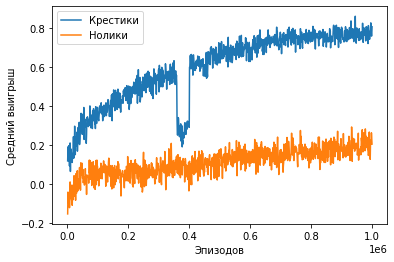

In [107]:
plot_results(results_2)
print(f'Средний выигрышь крестиков против случайной политики: {np.round(np.mean(results_2[1][-100:-1]), 3)}')
print(f'Средний выигрышь ноликов против случайной политики: {np.round(np.mean(results_2[2][-100:-1]), 3)}')

Как видим, при увелечении размерности доски всего на 1, Q-обучение требует гораздо большее количество эпизодов - увеличение в 5 раз не дало возможности обучиться модели с таким же результатам как на доске 3х3.

In [108]:
p_1 = Policy()
p_2 = Policy()
env = TicTacToe(5, 5, 5)

episodes = 2000000
test_each = 1000
print_each = 200000

results_3 = run_experiment(env, p_1, p_2, episodes, test_each, print_each)

 10%|█         | 200043/2000000 [21:53<11:40:31, 42.82it/s]

Episode 200000, cross reward: 0.204, nought reward: -0.072


 20%|██        | 400037/2000000 [43:21<10:28:37, 42.42it/s]

Episode 400000, cross reward: 0.308, nought reward: -0.15


 30%|███       | 600031/2000000 [1:04:42<8:43:59, 44.53it/s] 

Episode 600000, cross reward: 0.294, nought reward: -0.152


 40%|████      | 800043/2000000 [1:25:48<7:44:57, 43.01it/s] 

Episode 800000, cross reward: 0.338, nought reward: -0.128


 50%|█████     | 1000030/2000000 [1:46:55<6:34:31, 42.24it/s]

Episode 1000000, cross reward: 0.276, nought reward: -0.068


 60%|██████    | 1200043/2000000 [2:07:58<5:19:58, 41.67it/s]

Episode 1200000, cross reward: 0.306, nought reward: -0.108


 70%|███████   | 1400058/2000000 [2:29:04<3:46:02, 44.24it/s]

Episode 1400000, cross reward: 0.294, nought reward: -0.132


 80%|████████  | 1600027/2000000 [2:50:11<2:37:30, 42.32it/s]

Episode 1600000, cross reward: 0.334, nought reward: -0.094


 90%|█████████ | 1800027/2000000 [3:11:27<1:21:52, 40.71it/s]

Episode 1800000, cross reward: 0.31, nought reward: -0.124


100%|██████████| 2000000/2000000 [3:32:49<00:00, 156.62it/s]

Episode 2000000, cross reward: 0.33, nought reward: -0.082


Средний выигрышь крестиков против случайной политики: 0.306
Средний выигрышь ноликов против случайной политики: -0.097


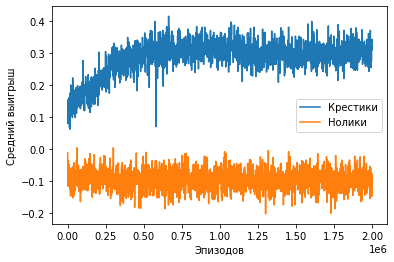

In [109]:
plot_results(results_3)
print(f'Средний выигрышь крестиков против случайной политики: {np.round(np.mean(results_3[1][-100:-1]), 3)}')
print(f'Средний выигрышь ноликов против случайной политики: {np.round(np.mean(results_3[2][-100:-1]), 3)}')

При заданных параметрах - не получилось эффективно обучить Q-стратегию для доски размера 5х5, при этом количество эпизодов и времени потребовалось значительно больше (2 млн эпизодов и ~3 часа времени).